# Libraries

In [4]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from textblob import TextBlob

# Loading the Files

Download the csv files into the `data/` directory.

In [5]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

# print("train.csv shape is ", trainingSet.shape)
# print("test.csv shape is ", testingSet.shape)

# print()

# print(trainingSet.head())
# print()
# print(testingSet.head())

# print()

# print(trainingSet.describe())

# trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
# plt.show()

# print()
# print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [15]:
def add_features_to(df, train_data=None):
    """Add features to the DataFrame."""
    
    # Compute helpfulness metrics
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'].fillna(0, inplace=True)
    
    df['IsHelpful'] = (df['HelpfulnessNumerator'] > 0).astype(int)
    df['HelpfulnessDifference'] = df['HelpfulnessNumerator'] - df['HelpfulnessDenominator']
    df['WeightedHelpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    
    # Compute user and product review history
    if train_data is not None:
        user_avg_scores = train_data.groupby('UserId')['Score'].mean()
        product_avg_scores = train_data.groupby('ProductId')['Score'].mean()
        overall_mean_score = train_data['Score'].mean()
    else:
        user_avg_scores = df.groupby('UserId')['Score'].mean()
        product_avg_scores = df.groupby('ProductId')['Score'].mean()
        overall_mean_score = df['Score'].mean()

    df['UserAvgScore'] = df['UserId'].map(user_avg_scores).fillna(overall_mean_score)
    df['ProductAvgScore'] = df['ProductId'].map(product_avg_scores).fillna(overall_mean_score)
    df['UserMedianScore'] = df['UserId'].map((train_data if train_data is not None else df).groupby('UserId')['Score'].median()).fillna(overall_mean_score)
    df['UserReviewTotal'] = df['UserId'].map((train_data if train_data is not None else df).groupby('UserId')['Score'].count()).fillna(0)

    # Compute textual features
    df['Text'] = df['Text'].fillna("").astype(str)
    df['ReviewWordCount'] = df['Text'].apply(lambda text: len(text.split()))
    df['UniqueWordCount'] = df['Text'].apply(lambda text: len(set(text.split())))

    # Perform sentiment analysis
    df['SentimentPolarity'] = df['Text'].apply(lambda text: TextBlob(text).sentiment.polarity)
    
    return df

if exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")
else:
    # Augment training data
    train_augmented = add_features_to(trainingSet)
    
    # Combine training and testing on 'Id'
    X_submission = pd.merge(train_augmented, testingSet, on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})
    
    # Augment submission set with train data stats
    X_submission = add_features_to(X_submission, trainingSet)
    
    # Separate training rows with non-null scores
    X_train = train_augmented[train_augmented['Score'].notna()]
    
    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)


# Sample + Split into training and testing set

In [7]:
# Split the training data into features and target variable
X = X_train.drop(columns=['Score'])
Y = X_train['Score']

# Split the training set into training and testing sets for offline evaluation
X_train, X_test, Y_train, Y_test = train_test_split(
    X,  # Features (excluding 'Score')
    Y,  # Target variable ('Score')
    test_size=0.25, 
    random_state=0 
)

# Check the dimensions of the resulting datasets
print(f"Training Set Shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Testing Set Shape: X_test: {X_test.shape}, Y_test: {Y_test.shape}")


Training Set Shape: X_train: (1114005, 23), Y_train: (1114005,)
Testing Set Shape: X_test: (371336, 23), Y_test: (371336,)


# Feature Selection

In [8]:
# Updated feature list with all additional features

features = [
    'HelpfulnessNumerator',
    'HelpfulnessDenominator',
    'Helpfulness',               # Derived from HelpfulnessNumerator and HelpfulnessDenominator
    'IsHelpful',                 # Derived from HelpfulnessNumerator
    'HelpfulnessDifference',     # Derived from HelpfulnessNumerator and HelpfulnessDenominator
    'WeightedHelpfulness',       # Derived from HelpfulnessNumerator and HelpfulnessDenominator
    'UserAvgScore',              # Derived from UserId in compute_user_product_history
    'ProductAvgScore',           # Derived from ProductId in compute_user_product_history
    'UserMedianScore',           # Derived from UserId in compute_user_product_history
    'UserReviewTotal',           # Derived from UserId in compute_user_product_history
    'ReviewWordCount',           # Derived from Text in compute_textual_features
    'UniqueWordCount',           # Derived from Text in compute_textual_features
    'SentimentPolarity'          # Derived from Text in compute_sentiment_analysis
]

# Selecting features for training and testing
X_train_select = X_train[features]
X_test_select = X_test[features]  # Assuming X_test has been defined similarly
X_submission_select = X_submission[features]

# Model Creation

In [12]:
model = GradientBoostingClassifier(n_estimators=130, learning_rate=0.2, random_state=42, n_iter_no_change=10)
model.fit(X_train_select, Y_train)

Y_test_predictions = model.predict(X_test_select)

# Model Evaluation

Accuracy on testing set =  0.650160501540384


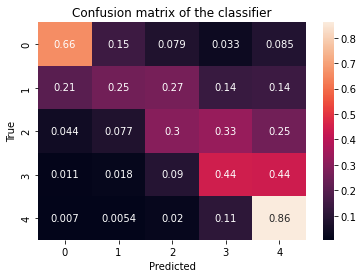

In [13]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [14]:

X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data2/submission.csv", index=False)